# **Rice Leaf Disease**

# **Introduction**
In this kernel we will build a Tensorflow_2.0 Keras model to classify three types of rice leaf diseases. These diseases include leaf smut, brown spot and bacterial leaf blight. The dataset consists of only 120 images. Normally, when using deep learning, one would not expect to get very good results with so few training images. However, by using image data augmentation combined with a pre-trained Mobilenet model our validation accuracy score is greater than 90%. In fact, while doing experiments I found that it was possible to get a 100% accuracy score by fine tuning either Keras Densenet169 or Pytorch Resnet18.

# **Data Summary**
1)120 jpg images of various sizes.

2)3 classes --> leaf smut, brown spot and bacterial leaf blight

3)40 images per class

4)There are no images of normal rice leaves i.e. not disease infected.

5)There are images in the dataset that appear to have been processed e.g. the background has been removed. Therefore, we have a mixture of raw and processed images.

## **Approch**
1)Resize all images to 224x224x3

2)Spliting the daaset into train and test

3) Scaling the images by dividing by 255 and Perform image augmentation using the Albumentations library. Image augmentation will help to reduce overfitting, improve model performance and help the model generalize better.

4) CNN technique is used and the visulization of model has done.Use Adam optimizer, categorical crossentropy loss and a constant learning rate of 0.0001

5)Fine tune a Mobilenet model that was pre-trained on imagenet.Use Adam optimizer, categorical crossentropy loss and a constant learning rate of 0.0001.

# **Importing the libraries**

In [29]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from IPython.display import HTML
import os
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D,Flatten,MaxPooling2D,Dropout,Dense,Activation

# **Prepare the data**

In [30]:
BATCH_SIZE = 32
IMAGE_SIZE = 224
CHANNELS=3
EPOCHS=50

In [31]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/data/leaf",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 119 files belonging to 3 classes.


In [32]:
class_names = dataset.class_names
class_names

['Bacterial leaf blight', 'Brown spot', 'Leaf smut']

In [33]:
leaf_smut_list = \
os.listdir('/content/drive/MyDrive/data/Leaf smut')
brown_spot_list = \
os.listdir('/content/drive/MyDrive/data/Brown spot')
bacterial_leaf_blight_list = \
os.listdir('/content/drive/MyDrive/data/Bacterial leaf blight1')

print(len(leaf_smut_list))
print(len(brown_spot_list))
print(len(bacterial_leaf_blight_list))

39
40
40


In [34]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 224, 224, 3)
[0 1 2 2 1 0 1 0 1 1 1 2 0 1 0 1 1 1 0 0 2 2 1 2 1 1 1 2 0 2 0 0]


In [35]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch[0].numpy())  ### converting into numpy

[[[228.      215.      207.     ]
  [228.93385 213.93385 206.93385]
  [227.71565 214.94334 207.171  ]
  ...
  [234.88623 223.88623 217.88623]
  [233.5601  221.30031 215.69582]
  [232.6228  221.6228  217.6228 ]]

 [[227.12112 214.12112 208.12112]
  [227.4933  213.5067  206.     ]
  [229.65848 216.88617 209.11383]
  ...
  [235.94235 224.94235 220.94235]
  [236.24126 225.24126 219.24126]
  [234.19946 223.19946 217.19946]]

 [[226.62277 213.62277 207.62277]
  [227.      214.      206.     ]
  [228.71413 215.94182 208.16948]
  ...
  [234.      223.      219.     ]
  [235.4244  224.4244  218.4244 ]
  [235.92725 224.92725 218.92725]]

 ...

 [[236.      218.      214.     ]
  [233.48883 218.48883 211.48883]
  [230.      219.      213.     ]
  ...
  [234.97766 221.97766 215.97766]
  [233.62067 220.62067 212.62067]
  [228.11163 217.11163 211.11163]]

 [[236.49329 219.49329 212.49329]
  [234.      219.      212.     ]
  [232.      219.      211.     ]
  ...
  [233.50671 220.50671 214.50671]
  [2

In [36]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch[0].shape) 

(224, 224, 3)


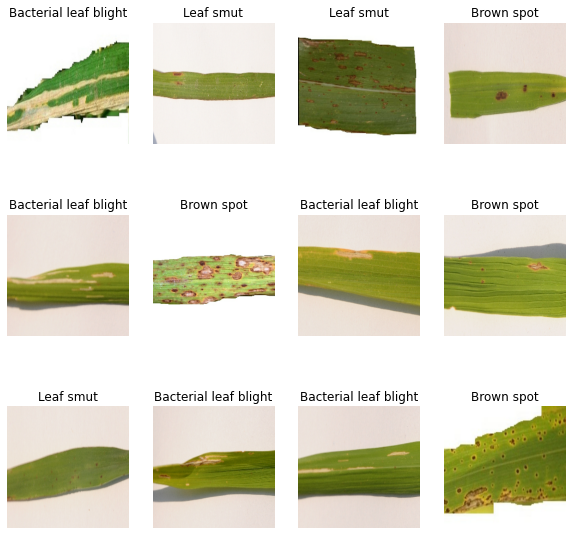

In [37]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

# **Spliting the data**

In [38]:
def get_dataset_partitions_tf(ds, train_split=0.8, test_split=0.2, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    #val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
  #  val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size)
    
    return train_ds, test_ds

In [39]:
train_ds,test_ds = get_dataset_partitions_tf(dataset)

In [40]:
len(train_ds)

3

In [41]:
len(test_ds)

1

In [42]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
#val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

## **Scaling the data**

In [43]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

## **Data Augmentation**

In [44]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

## **Model Bulding using CNN** 

In [45]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])
model.build(input_shape=input_shape)

In [46]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_3 (Sequential)   (32, 224, 224, 3)         0         
                                                                 
 conv2d_6 (Conv2D)           (32, 222, 222, 32)        896       
                                                                 
 max_pooling2d_6 (MaxPooling  (32, 111, 111, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (32, 109, 109, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPooling  (32, 54, 54, 64)         0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (32, 52, 52, 64)         

In [47]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy'])

In [48]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=test_ds,
    verbose=1,
    epochs=50,
)

Epoch 1/50
3/3 [==============================] - 11s 3s/step - loss: 1.0993 - accuracy: 0.2989 - val_loss: 1.0936 - val_accuracy: 0.4062
Epoch 2/50
3/3 [==============================] - 8s 3s/step - loss: 1.0954 - accuracy: 0.3448 - val_loss: 1.0843 - val_accuracy: 0.4688
Epoch 3/50
3/3 [==============================] - 8s 3s/step - loss: 1.0879 - accuracy: 0.4023 - val_loss: 1.0741 - val_accuracy: 0.3438
Epoch 4/50
3/3 [==============================] - 8s 3s/step - loss: 1.0701 - accuracy: 0.4253 - val_loss: 1.0492 - val_accuracy: 0.5000
Epoch 5/50
3/3 [==============================] - 8s 3s/step - loss: 1.0346 - accuracy: 0.4943 - val_loss: 1.0143 - val_accuracy: 0.5312
Epoch 6/50
3/3 [==============================] - 8s 3s/step - loss: 1.0013 - accuracy: 0.5287 - val_loss: 1.0413 - val_accuracy: 0.5312
Epoch 7/50
3/3 [==============================] - 8s 3s/step - loss: 0.9849 - accuracy: 0.5747 - val_loss: 1.0170 - val_accuracy: 0.5000
Epoch 8/50
3/3 [========================

In [49]:
scores = model.evaluate(test_ds)

1/1 [==============================] - 1s 692ms/step - loss: 0.4409 - accuracy: 0.9062


In [50]:
history.params

{'epochs': 50, 'steps': 3, 'verbose': 1}

In [51]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

# **Accuracy plot**

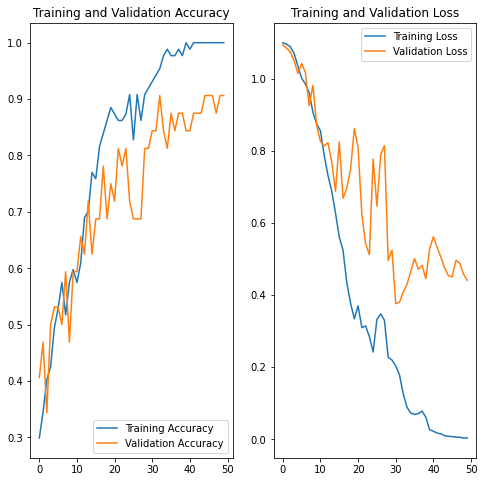

In [52]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [53]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

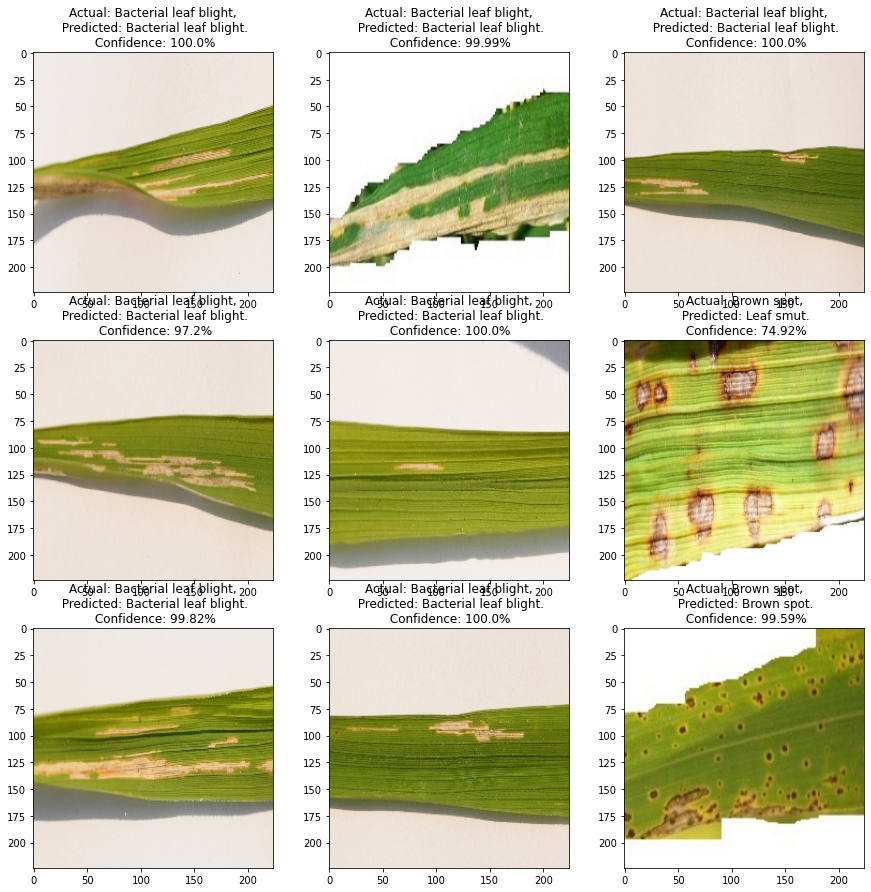

In [54]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

## **Transfer Learning**

In [55]:
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.metrics import categorical_accuracy

from tensorflow.keras.callbacks import (EarlyStopping, ReduceLROnPlateau, 
                                        ModelCheckpoint, CSVLogger, LearningRateScheduler)
from tensorflow.keras.applications.mobilenet import MobileNet

model = MobileNet(weights='imagenet')

# Exclude the last 2 layers of the above model.
x = model.layers[-2].output
# Create a new dense layer for predictions
# 3 corresponds to the number of classes
predictions = Dense(3, activation='softmax')(x)

# inputs=model.input selects the input layer, outputs=predictions refers to the
# dense layer we created above.

model = Model(inputs=model.input, outputs=predictions)

model.summary()

17235968/17225924 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128    

In [56]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy'])

In [ ]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=test_ds,
    verbose=1,
    epochs=50,
)

Epoch 1/50
3/3 [==============================] - 20s 6s/step - loss: 2.9279 - accuracy: 0.6092 - val_loss: 5.6854 - val_accuracy: 0.3125
Epoch 2/50
3/3 [==============================] - 16s 5s/step - loss: 0.3774 - accuracy: 0.9425 - val_loss: 2.8476 - val_accuracy: 0.5938
Epoch 3/50
3/3 [==============================] - 16s 5s/step - loss: 1.1164 - accuracy: 0.9310 - val_loss: 7.8747 - val_accuracy: 0.3750
Epoch 4/50
3/3 [==============================] - 16s 5s/step - loss: 0.0026 - accuracy: 1.0000 - val_loss: 15.8974 - val_accuracy: 0.2812
Epoch 5/50
3/3 [==============================] - 16s 5s/step - loss: 0.0268 - accuracy: 0.9885 - val_loss: 25.8369 - val_accuracy: 0.2812
Epoch 6/50
3/3 [==============================] - 16s 5s/step - loss: 0.0571 - accuracy: 0.9885 - val_loss: 30.4246 - val_accuracy: 0.2812
Epoch 7/50
3/3 [==============================] - ETA: 0s - loss: 0.0023 - accuracy: 1.0000

In [ ]:
scores = model.evaluate(test_ds)

In [ ]:
history.params

In [ ]:
history.history.keys()

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

## **Accuracy plot**

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [ ]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

In [ ]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")